In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import arviz

import torch
import torch.distributions as td
import torch.nn.functional as F

from tqdm.auto import tqdm
from tabulate import tabulate
from collections import OrderedDict, namedtuple

import pyro
import pyro.distributions as pd
from pyro import poutine

In [3]:
pyro.__version__, torch.__version__

('1.6.0', '1.8.1+cu102')

In [4]:
random.seed(0)
np.random.seed(0)
pyro.set_rng_seed(0)
torch.manual_seed(0)
rng = np.random.RandomState(0)

In [5]:
D = 2
S = 1000
data_samples = [
    td.Normal(torch.zeros(D), torch.ones(D)).sample((S,)),
    td.Normal(torch.zeros(D), torch.ones(D)).sample((S,)),
    td.Normal(torch.zeros(D), torch.ones(D)/2.).sample((S,)),
    td.Normal(torch.zeros(D), torch.ones(D)*2.).sample((S,)),
    td.Normal(td.Normal(0., 1.).sample((D,)), td.LogNormal(0., 1.).sample((D,))).sample((S,)),
    td.LowRankMultivariateNormal(torch.zeros(D), td.Normal(0., 1.).sample((D,2)), td.LogNormal(0., 1.).sample((D,))).sample((S,)),
]
data = torch.stack([t for t in data_samples], 1)
_, G, _ = data.shape
print(f"S={S} G={G} D={D} data={data.shape}")

S=1000 G=6 D=2 data=torch.Size([1000, 6, 2])


In [6]:
group_names = ['N(0,1)', 'N(0,1)', 'N(0,0.5)', 'N(0,2)', 'N(N(0,1),LN(0,1))', 'Rank2MVN']

In [7]:
from probabll.bda.mmm import Family, MixedMembershipRD, Plotting

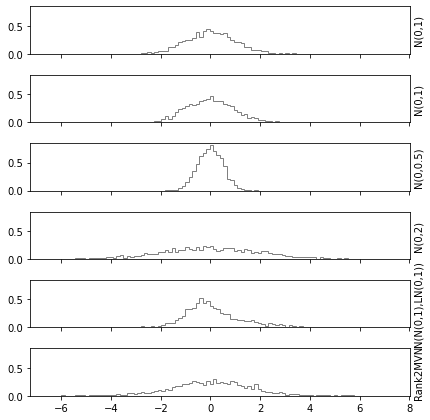

In [8]:
_ = Plotting.obs(data, group_names=group_names, sharey='col')

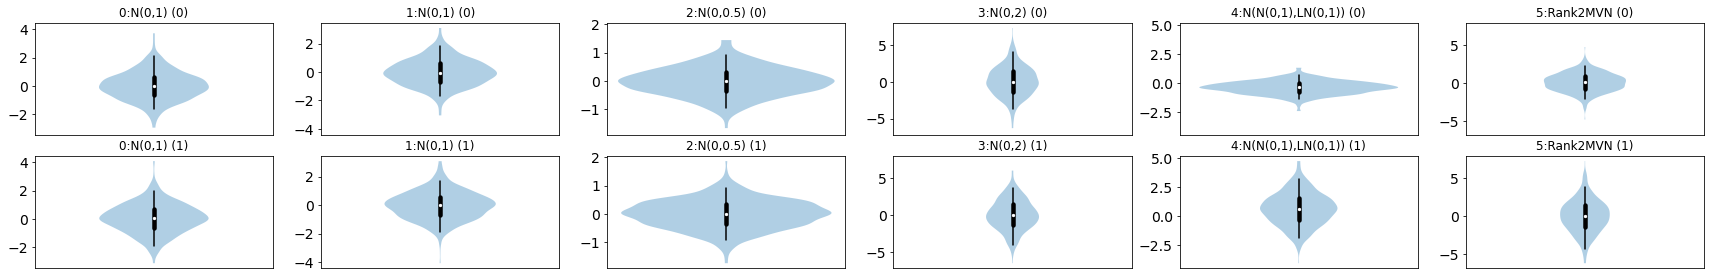

In [9]:
_ = Plotting.obs_dims(data, group_names=group_names, figsize=(4, 2), sharey='col')

In [10]:
model = MixedMembershipRD(    
    Family.LowRankMVN(
        dim=D, rank=1, 
        mu_loc=0., mu_scale=10., 
        cov_diag_alpha=0.1, cov_diag_beta=1., 
        cov_factor_loc=0., cov_factor_scale=10., 
        delta=False),
    T=10, 
    DP_alpha=0.1, 
    device=torch.device('cpu')
)

In [11]:
x = model.prepare(data.cpu().numpy())
x.shape

torch.Size([1000, 6, 2])

In [12]:
model.print_model_shapes()

    Trace Shapes:                    
     Param Sites:                    
    Sample Sites:                    
  components dist              |     
            value           10 |     
         log_prob              |     
          mu dist           10 | 2   
            value           10 | 2   
         log_prob           10 |     
  cov_factor dist           10 | 2  1
            value           10 | 2  1
         log_prob           10 |     
    cov_diag dist           10 | 2   
            value           10 | 2   
         log_prob           10 |     
         DPs dist              |     
            value            6 |     
         log_prob              |     
        beta dist            6 | 9   
            value            6 | 9   
         log_prob            6 |     
       omega dist              | 6 10
            value              | 6 10
         log_prob              |     
      groups dist              |     
            value            6 |     
         log

In [13]:
model.print_guide_shapes()

   Trace Shapes:            
    Param Sites:            
           kappa     6 9    
          mu_loc    10 2    
        mu_scale    10 2    
    cov_diag_loc    10 2    
  cov_diag_scale    10 2    
  cov_factor_loc 10  2 1    
cov_factor_scale 10  2 1    
   Sample Sites:            
 components dist       |    
           value    10 |    
        log_prob       |    
         mu dist    10 | 2  
           value    10 | 2  
        log_prob    10 |    
   cov_diag dist    10 | 2  
           value    10 | 2  
        log_prob    10 |    
 cov_factor dist    10 | 2 1
           value    10 | 2 1
        log_prob    10 |    
        DPs dist       |    
           value     6 |    
        log_prob       |    
       beta dist     6 | 9  
           value     6 | 9  
        log_prob     6 |    


In [14]:
model.fit(x, 2000, lr=0.01, clip_norm=10.)

  0%|          | 0/2000 [00:00<?, ?it/s]

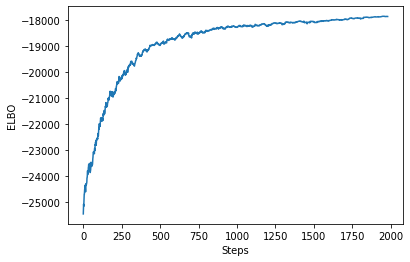

In [15]:
Plotting.elbo(model)

In [16]:
posterior = model.posterior_predict(num_samples=1000)

In [17]:
print(tabulate([[rv_name, rv_t.shape] for rv_name, rv_t in posterior.items()]))

----------  -------------------------------
mu          torch.Size([1000, 1, 10, 2])
cov_factor  torch.Size([1000, 1, 10, 2, 1])
cov_diag    torch.Size([1000, 1, 10, 2])
beta        torch.Size([1000, 1, 6, 9])
z           torch.Size([1000, 1000, 6])
obs         torch.Size([1000, 1000, 6, 2])
omega       torch.Size([1000, 1, 1, 6, 10])
----------  -------------------------------


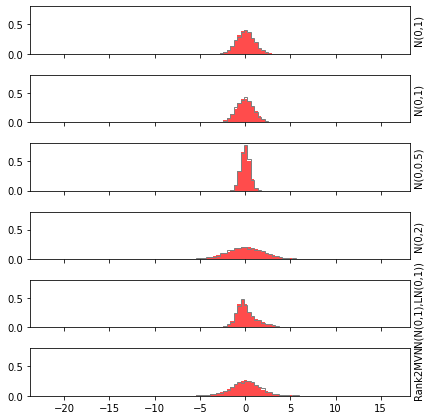

In [18]:
_ = Plotting.obs(x, pred=posterior['obs'], group_names=group_names, sharey='col')

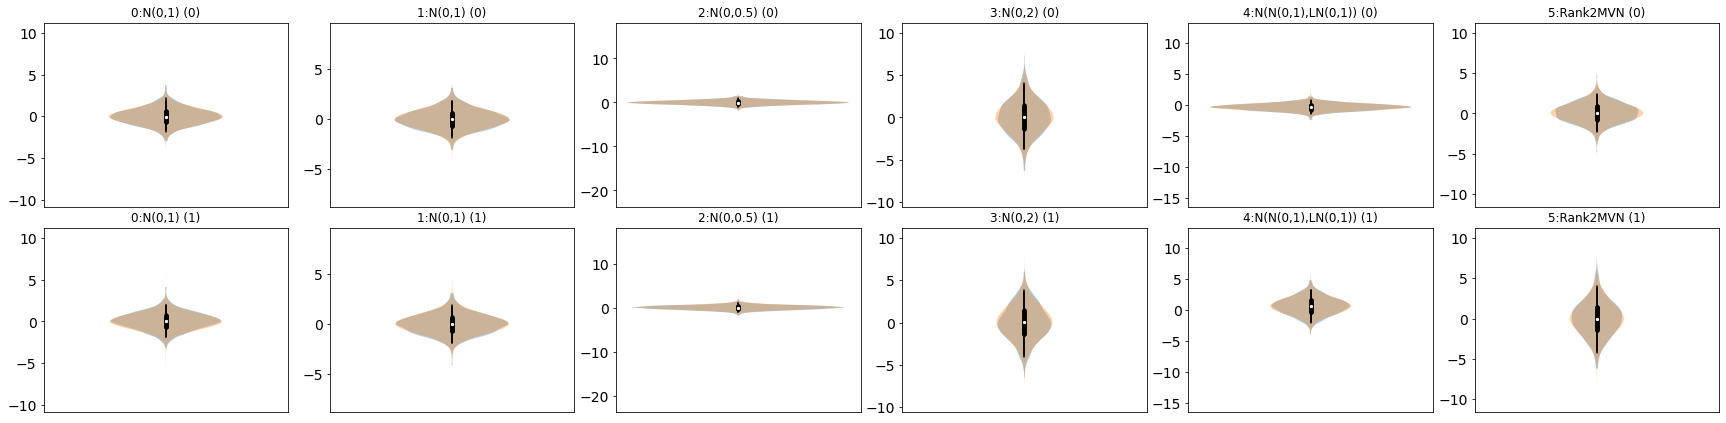

In [19]:
_ = Plotting.obs_dims(x, pred=posterior['obs'], group_names=group_names, sharey='col', figsize=(4, 3))

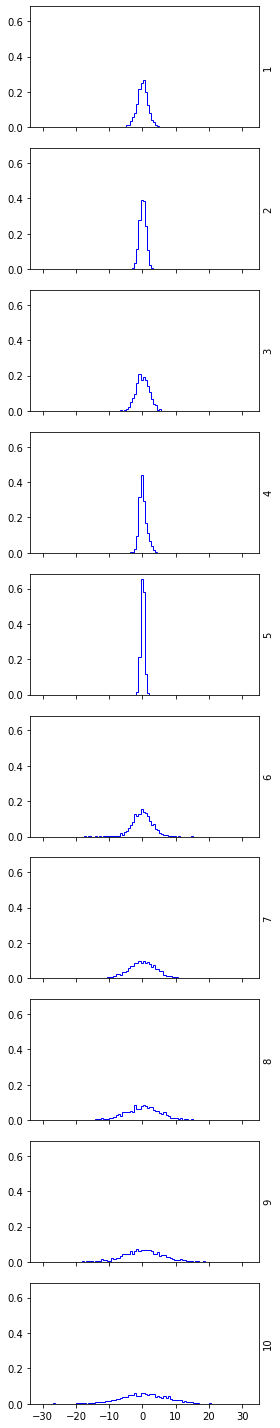

In [20]:
_ = Plotting.components(posterior, model, marginal=True)

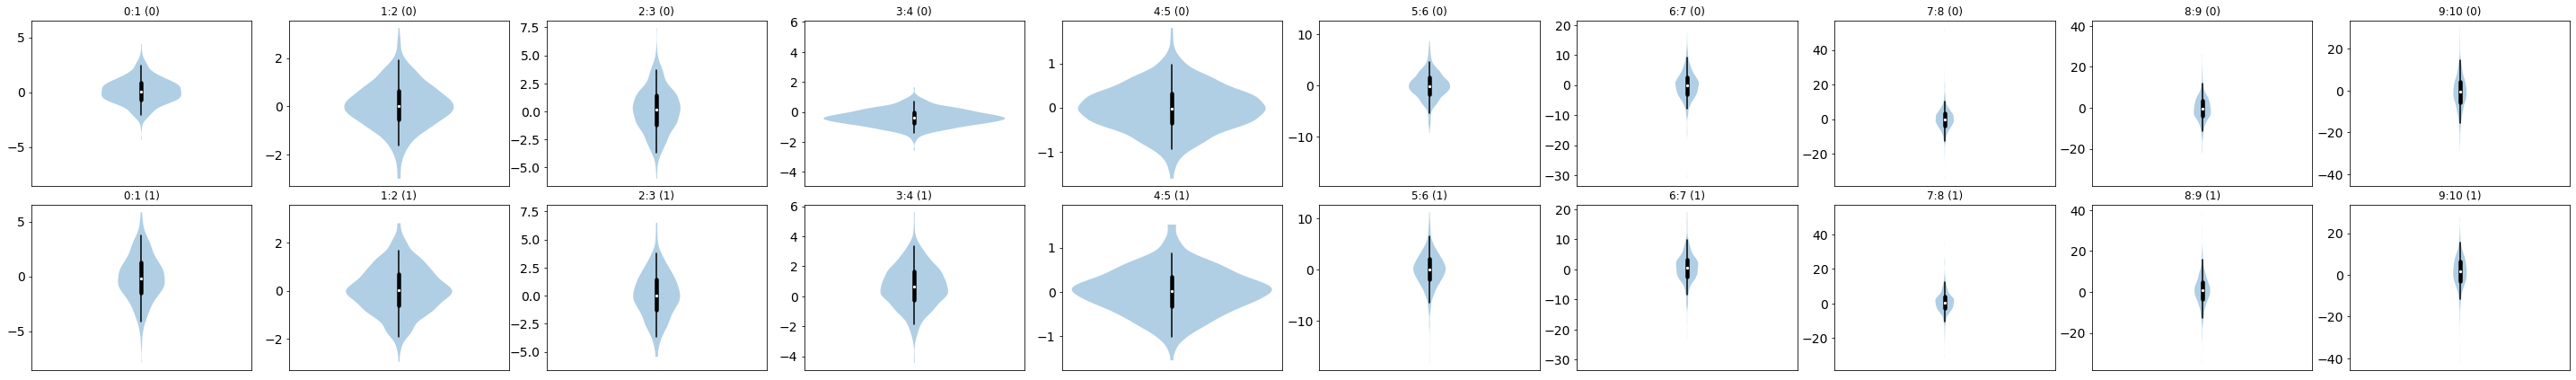

In [21]:
_ = Plotting.components(posterior, model, sharey='col', marginal=False, figsize=(4, 3))

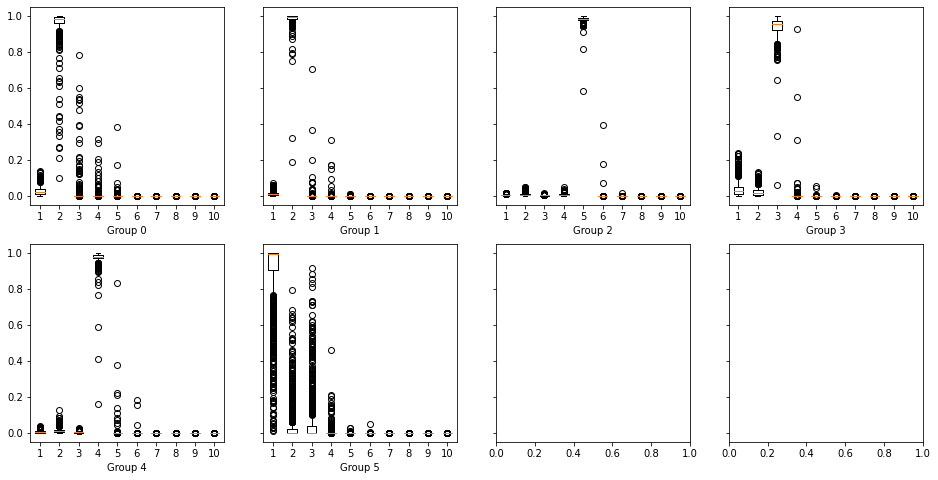

In [22]:
_ = Plotting.mixture_weights(posterior, model)

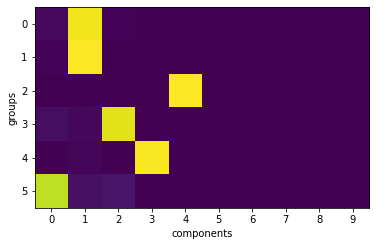

In [23]:
_ = Plotting.mean_mixture_weights(posterior, model)

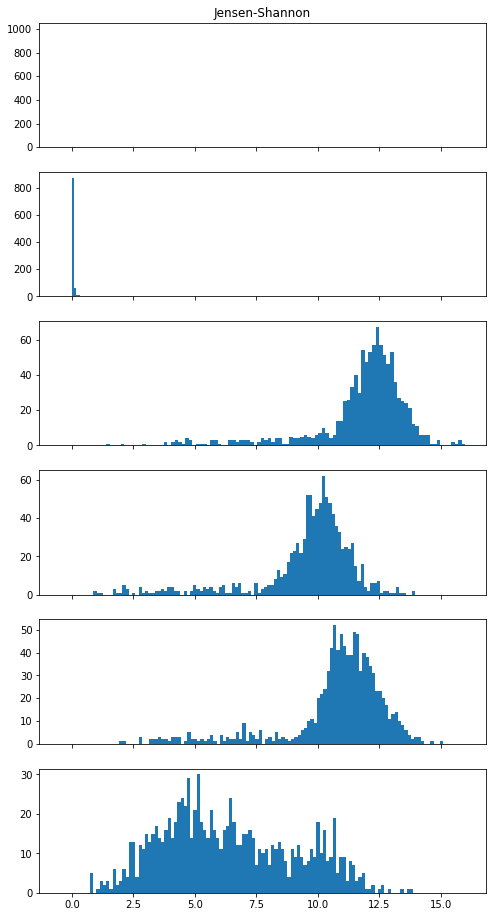

In [24]:
_ = Plotting.compare_mixture_weights(posterior, model)

In [25]:
p_from = td.LowRankMultivariateNormal(
    torch.zeros(D, device=model.device),
    torch.zeros([D, 2], device=model.device),
    torch.ones(D, device=model.device)
)

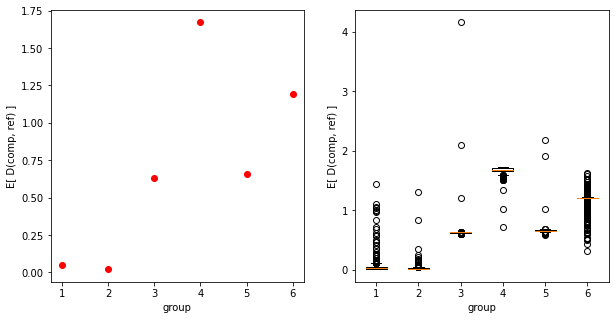

In [26]:
_ = Plotting.expected_divergence(p_from, posterior, model)

Ideally the first 2 groups should have divergence close to 0 in the plots above.